<a href="https://www.kaggle.com/code/sukruthag/task-4-data-analysis-on-global-terrorism?scriptVersionId=110200840" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

**Task 4 - Exploratory Data Analysis - Terrorism**
1. Perform EDA on dataset 'Global Terrorism'
2. As a security/defence analyst, try to find out the hot zone of terrorism
3. What all security issues and insights you can derive by EDA?



In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from PIL import Image
from array import array
import sys
from wordcloud import WordCloud 
from nltk.corpus import stopwords
import plotly.express as px
import seaborn as sns
import folium
from folium.plugins import MarkerCluster
from plotly.offline import iplot, init_notebook_mode

In [2]:
df = pd.read_csv("../input/tsf-datasets/globalterrorismdb_0718dist.csv", low_memory=False, encoding='latin1')
df.head()

eventid  iyear  imonth  iday approxdate  extended resolution  country  \
0  197000000001   1970       7     2        NaN         0        NaN       58   
1  197000000002   1970       0     0        NaN         0        NaN      130   
2  197001000001   1970       1     0        NaN         0        NaN      160   
3  197001000002   1970       1     0        NaN         0        NaN       78   
4  197001000003   1970       1     0        NaN         0        NaN      101   

          country_txt  region  ... addnotes scite1 scite2  scite3  dbsource  \
0  Dominican Republic       2  ...      NaN    NaN    NaN     NaN      PGIS   
1              Mexico       1  ...      NaN    NaN    NaN     NaN      PGIS   
2         Philippines       5  ...      NaN    NaN    NaN     NaN      PGIS   
3              Greece       8  ...      NaN    NaN    NaN     NaN      PGIS   
4               Japan       4  ...      NaN    NaN    NaN     NaN      PGIS   

   INT_LOG  INT_IDEO INT_MISC INT_ANY  related  
0        0         0        0       0      NaN  
1        0         1        1       1      NaN  
2       -9        -9        1       1      NaN  
3       -9        -9        1       1      NaN  
4       -9        -9        1       1      NaN  

[5 rows x 135 columns]

# **Data Preprocessing**

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181691 entries, 0 to 181690
Columns: 135 entries, eventid to related
dtypes: float64(55), int64(22), object(58)
memory usage: 187.1+ MB


In [4]:
df.columns

Index(['eventid', 'iyear', 'imonth', 'iday', 'approxdate', 'extended',
       'resolution', 'country', 'country_txt', 'region',
       ...
       'addnotes', 'scite1', 'scite2', 'scite3', 'dbsource', 'INT_LOG',
       'INT_IDEO', 'INT_MISC', 'INT_ANY', 'related'],
      dtype='object', length=135)

In [5]:
df.rename(columns={'iyear':'Year','imonth':'Month','iday':'Day','city':'City','country_txt':'Country','provstate':'state',
                       'region_txt':'Region','attacktype1_txt':'AttackType','target1':'Target','nkill':'Killed',
                       'nwound':'Wounded','summary':'Summary','gname':'Group','targtype1_txt':'Target_type',
                       'weaptype1_txt':'Weapon_type','motive':'Motive'},inplace=True)

In [6]:
df=df[['Year','Month','Day','Country','Region','state','latitude','longitude','AttackType','Killed','Wounded','Target','Group','Target_type','Weapon_type','Motive']]
df.head()

Year  Month  Day             Country                       Region    state  \
0  1970      7    2  Dominican Republic  Central America & Caribbean      NaN   
1  1970      0    0              Mexico                North America  Federal   
2  1970      1    0         Philippines               Southeast Asia   Tarlac   
3  1970      1    0              Greece               Western Europe   Attica   
4  1970      1    0               Japan                    East Asia  Fukouka   

    latitude   longitude                      AttackType  Killed  Wounded  \
0  18.456792  -69.951164                   Assassination     1.0      0.0   
1  19.371887  -99.086624     Hostage Taking (Kidnapping)     0.0      0.0   
2  15.478598  120.599741                   Assassination     1.0      0.0   
3  37.997490   23.762728               Bombing/Explosion     NaN      NaN   
4  33.580412  130.396361  Facility/Infrastructure Attack     NaN      NaN   

                    Target                               Group  \
0             Julio Guzman                              MANO-D   
1  Nadine Chaval, daughter  23rd of September Communist League   
2                 Employee                             Unknown   
3             U.S. Embassy                             Unknown   
4           U.S. Consulate                             Unknown   

                   Target_type Weapon_type Motive  
0  Private Citizens & Property     Unknown    NaN  
1      Government (Diplomatic)     Unknown    NaN  
2          Journalists & Media     Unknown    NaN  
3      Government (Diplomatic)  Explosives    NaN  
4      Government (Diplomatic)  Incendiary    NaN

In [7]:
df.isnull().sum()

Year                0
Month               0
Day                 0
Country             0
Region              0
state             421
latitude         4556
longitude        4557
AttackType          0
Killed          10313
Wounded         16311
Target            636
Group               0
Target_type         0
Weapon_type         0
Motive         131130
dtype: int64

In [8]:
df.dropna(inplace=True, axis=0)

**Creating a masking function for earth word cloud**

In [9]:
earth = np.array(Image.open("../input/terror/terror2.png"))
# array([[0, 0, 0, ..., 0, 0, 0],
#        [0, 0, 0, ..., 0, 0, 0],
#        [0, 0, 0, ..., 0, 0, 0],
#        ...,
#        [0, 0, 0, ..., 0, 0, 0],
#        [0, 0, 0, ..., 0, 0, 0],
#        [0, 0, 0, ..., 0, 0, 0]], dtype = np.uint8)

**Function to swap the number 0 to 255(pixels)**

In [10]:
def transform_format(val):
    if val == 0:
        return 255
    else:
        return val

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning:

In a future version of pandas all arguments of Series.dropna will be keyword-only



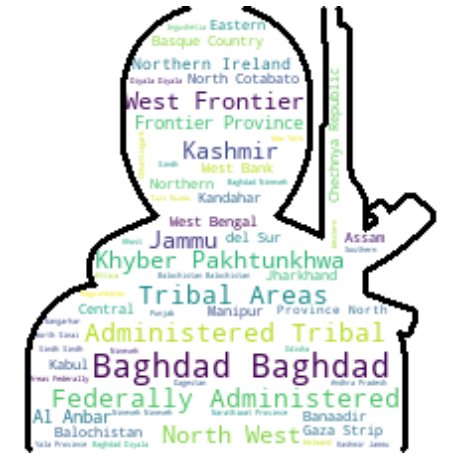

In [11]:
# Transform mask into a new one that will work with the function:
transformed_earth_mask = np.ndarray((earth.shape[0],earth.shape[1]), np.int32)

for i in range(len(earth)):
    transformed_earth_mask[i] = list(map(transform_format, earth[i]))
    
cities = df.state.dropna(False)    
wc = WordCloud(background_color = 'white', max_words = 1000, mask = transformed_earth_mask, 
               stopwords = stopwords.words('english'), contour_width = 3, contour_color = 'black')
wc.generate(' '.join(cities))

# #store to file
# wc.to_file('../input/images/earth1.png')

plt.figure(figsize = [8,10])
plt.imshow(wc, interpolation = 'bilinear')
plt.axis('off')
plt.show()

# **Correlation Analysis**

<AxesSubplot:>

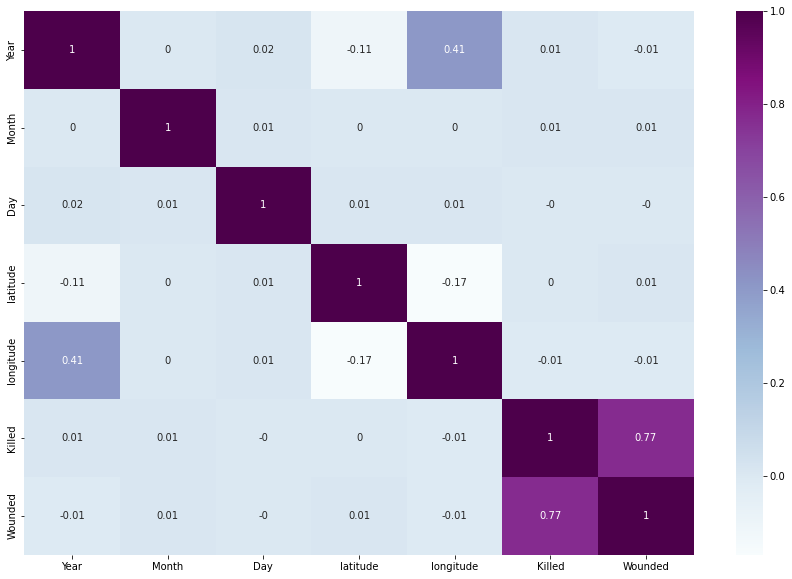

In [12]:
plt.figure(figsize=(15,10))
sns.heatmap(np.round(df.corr(),2), annot = True, cmap = 'BuPu')


In [13]:
df.groupby('Country')['Killed'].sum().sort_values(ascending = False).head(20)

Country
Iraq                                34731.0
Pakistan                            12375.0
Afghanistan                          9636.0
India                                8299.0
Algeria                              3985.0
United States                        3347.0
Sri Lanka                            3180.0
Somalia                              3134.0
Russia                               2923.0
Nigeria                              2861.0
Philippines                          2367.0
Colombia                             2152.0
Yemen                                1893.0
Thailand                             1543.0
Sudan                                1480.0
Democratic Republic of the Congo     1433.0
Nepal                                1248.0
Syria                                1037.0
Uganda                                984.0
Turkey                                982.0
Name: Killed, dtype: float64

In [14]:
top_country = df.groupby('Country')['Killed'].sum().sort_values(ascending = False).to_frame().reset_index().head(20)
px.bar(data_frame = top_country, x= 'Country', y='Killed', color = 'Killed', template = 'plotly_dark')

array([[<AxesSubplot:title={'center':'Year'}>,
        <AxesSubplot:title={'center':'Month'}>,
        <AxesSubplot:title={'center':'Day'}>],
       [<AxesSubplot:title={'center':'latitude'}>,
        <AxesSubplot:title={'center':'longitude'}>,
        <AxesSubplot:title={'center':'Killed'}>],
       [<AxesSubplot:title={'center':'Wounded'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

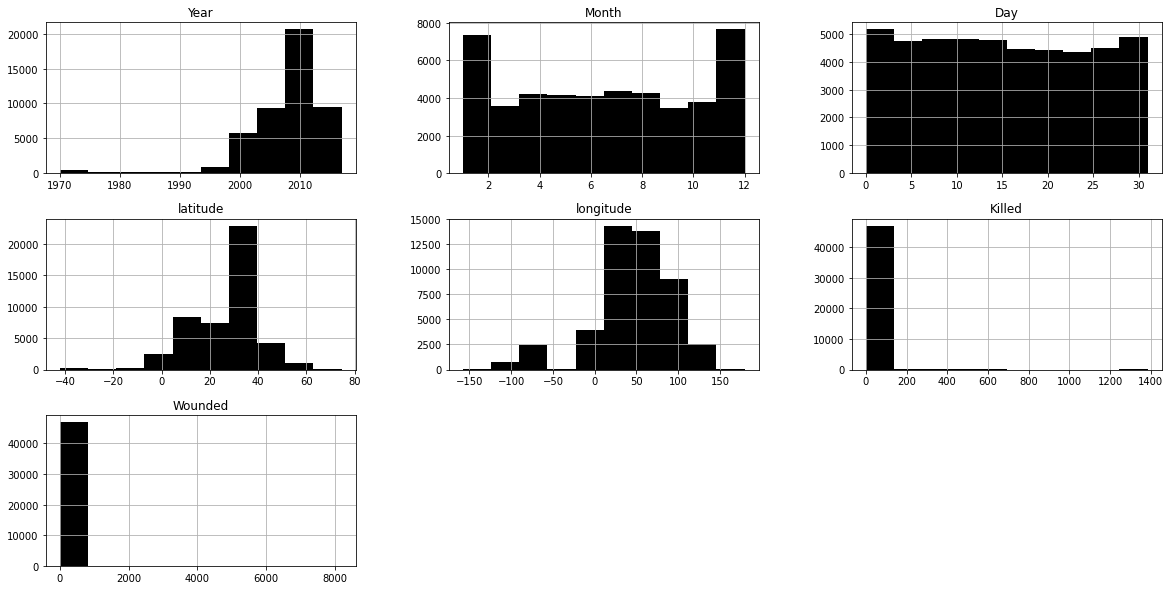

In [15]:
df.hist(figsize = (20,10), color = 'black')

In [16]:
df['Year'].value_counts(dropna = False).sort_index()

1970     222
1971     111
1972      40
1973      25
1974      40
1975      26
1976      30
1977      18
1978      41
1979      13
1980      23
1981      22
1982      27
1983      20
1984      46
1985      26
1986      37
1987      27
1988      28
1989      29
1990      27
1991      28
1992      28
1994      34
1995      25
1996      13
1997      21
1998     759
1999    1231
2000    1597
2001    1771
2002    1223
2003    1139
2004    1012
2005    1781
2006    2477
2007    2907
2008    4428
2009    4594
2010    4786
2011    4921
2012    1890
2013    2387
2014    1898
2015    1788
2016    1693
2017    1670
Name: Year, dtype: int64

# **Number of Terrorist Activities each year**

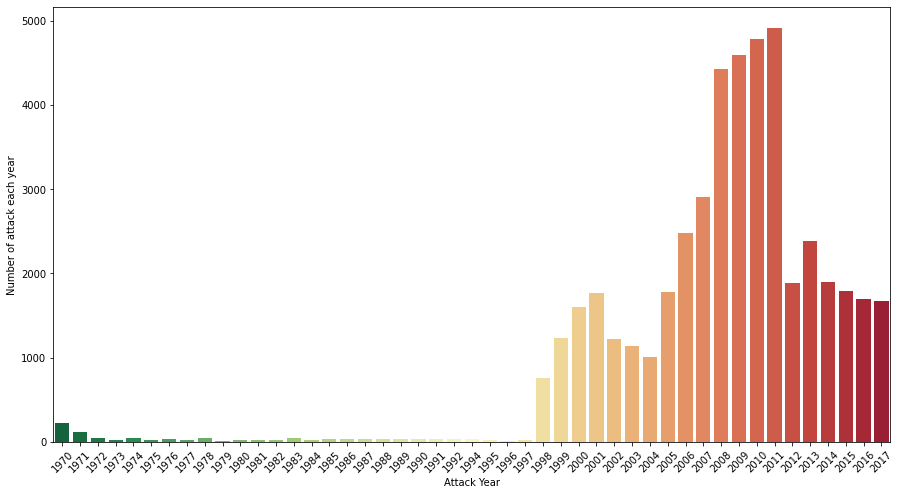

In [17]:
x_year = df['Year'].unique()
y_count_year = df['Year'].value_counts(dropna = False).sort_index()
plt.figure(figsize = (15,8))
sns.barplot(x = x_year, y = y_count_year, palette='RdYlGn_r')
plt.xticks(rotation = 45)
plt.xlabel('Attack Year')
plt.ylabel('Number of attack each year')
plt.style.use('dark_background')
plt.show()
    

In [18]:
total = df.groupby(['Country'], as_index = False).count()
globe = px.choropleth(total, locations = 'Country', locationmode = 'country names', color = 'Year', 
                       hover_name='Country', projection = 'orthographic', title = 'Number of Terrorist Attacks',
                       labels = {'Year':'Attacks'})
globe.show()

# **Number of Terrorist Activities by region in each year**

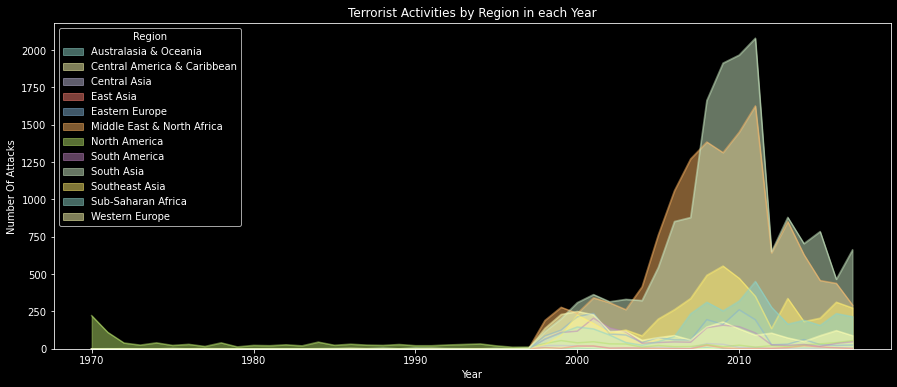

In [19]:
pd.crosstab(df.Year, df.Region).plot(kind = 'area', figsize = (15,6), stacked = False)
plt.title('Terrorist Activities by Region in each Year')
plt.ylabel('Number Of Attacks')
plt.style.use('dark_background')
plt.show()

# **Methods of Attack**

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



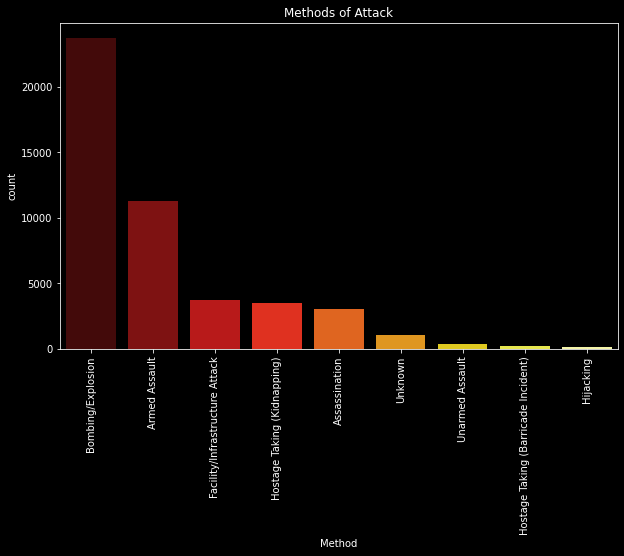

In [20]:
plt.figure(figsize = (10,6))
sns.countplot(df['AttackType'], order = df['AttackType'].value_counts().index, palette='hot')
plt.xticks(rotation = 90)
plt.xlabel('Method')
plt.title('Methods of Attack')
plt.style.use('dark_background')
plt.show()

# **Top Countries Affected by the Attack**

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



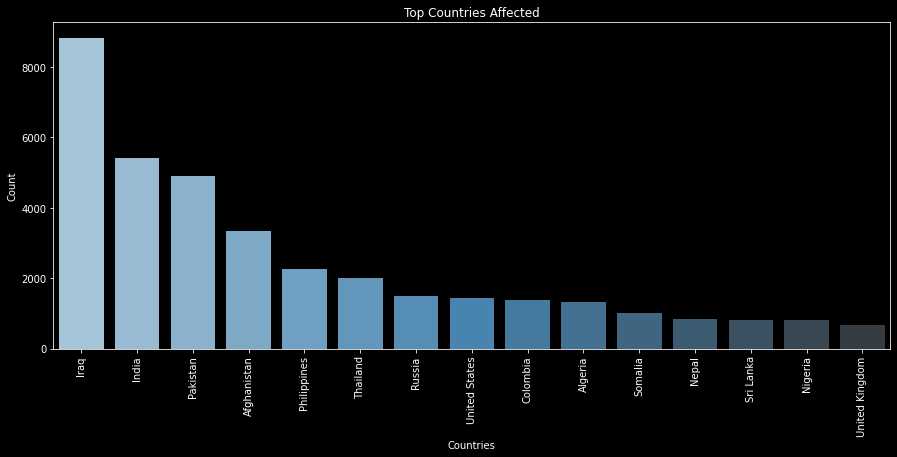

In [21]:
plt.subplots(figsize=(15,6))
sns.barplot(df['Country'].value_counts()[:15].index,df['Country'].value_counts()[:15].values,palette='Blues_d')
plt.title('Top Countries Affected')
plt.xlabel('Countries')
plt.ylabel('Count')
plt.style.use('dark_background')
plt.xticks(rotation= 90)
plt.show()

# **Top Terrorist Organisations**

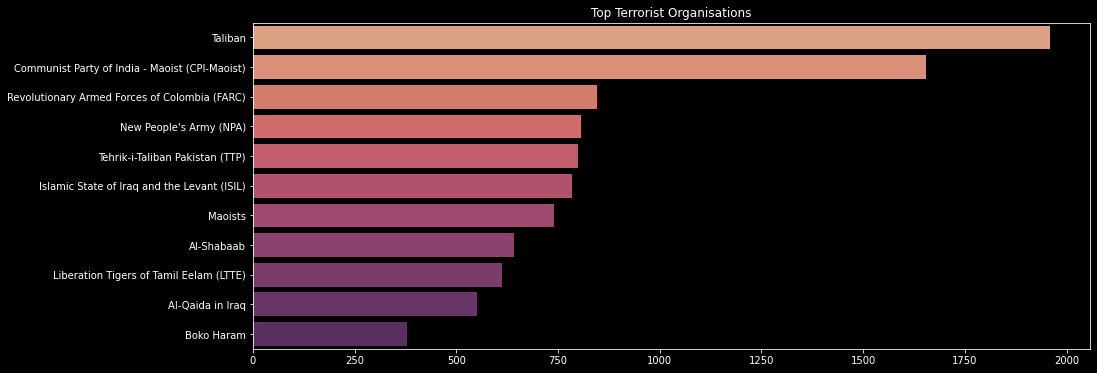

In [22]:
plt.subplots(figsize = (15,6))
sns.barplot(y=df['Group'].value_counts()[1:12].index, x = df['Group'].value_counts()[1:12].values, palette = 'flare')
plt.title('Top Terrorist Organisations')
plt.show()

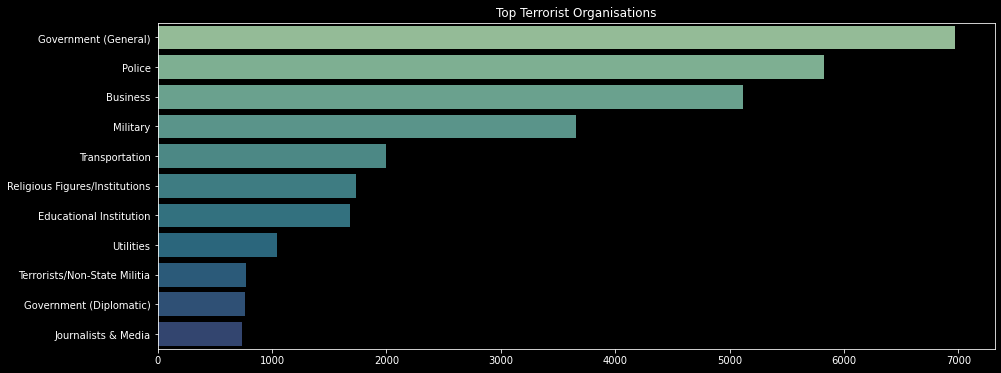

In [23]:
plt.subplots(figsize = (15,6))
sns.barplot(y=df['Target_type'].value_counts()[1:12].index, x = df['Target_type'].value_counts()[1:12].values, palette = 'crest')
plt.title('Top Terrorist Organisations')
plt.show()

# **2011 Terrorist Attack CityWise**

In [24]:
year=df[df['Year']==2011]
mapData=year.loc[:,'state':'longitude']
mapData=mapData.dropna().values.tolist()

maps = folium.Map(location = [0, 50], tiles='CartoDB positron', zoom_start=2) 
# clustered marker
markerCluster = folium.plugins.MarkerCluster().add_to(maps)
for i in range(0, len(mapData)):
    folium.Marker(location=[mapData[i][1],mapData[i][2]],
                  popup = mapData[i][0]).add_to(markerCluster)
maps

# **Conclusion**

* From word cloud, the cities that were attacked the most are Baghdad, Jammu and Kashmir,Tribal Areas and so on.
* High correlation between wounded and killed attributes.
* Iraq has the highest number of deaths
* According to the given dataset, 2011 had the highest number of terrorist attacks
* Bombing/Explosion was the most common type of terrorist attack
* Taliban is the top most terrorist organisation